In [41]:
import yaml
import pandas as pd
import time
from backend.utils.data_preprocessor import DataPreprocessor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = "1h"

training_file_path: str = f"../data/twelvedata/train ({interval}).csv"
validation_file_path: str = f"../data/twelvedata/feature time series ({interval})/AAPL_feature_time_series.csv"

start_time = time.time()
pd.set_option('display.max_columns', None)

training_df = pd.read_csv(training_file_path)
validation_df = pd.read_csv(validation_file_path)


In [42]:
import numpy as np

training_preprocessor = DataPreprocessor(training_df)
validation_preprocessor = DataPreprocessor(validation_df)

X_train = training_preprocessor.target_data_batched
y_train = training_preprocessor.target_data_batched_labels

X_val = validation_preprocessor.target_data_batched
y_val = validation_preprocessor.target_data_batched_labels

print("Training Dataset shape:", training_df.shape)
print("Validation Dataset shape:", validation_df.shape)

end_time = time.time()
loading_time = end_time - start_time
print("Loading time: ", loading_time)

# for column in training_preprocessor.target_data.columns:
    # print(column)
    # print(training_preprocessor.target_data[column].isnull().sum())
    # print(training_preprocessor.target_data[column].isin([np.inf, -np.inf]).sum())
training_preprocessor.target_data

Training Dataset shape: (74550, 32)
Validation Dataset shape: (4970, 32)
Loading time:  8.835588932037354


,open,high,low,close,volume,percent_b,atr,macd,macd_signal,macd_hist,adx,sma,ema,rsi,%K,%D,vpt,day,hour,open change,high change,low change,close change,price movement,price range,price trend,open trend,high trend,low trend,close trend,volume trend,target change,target trend,target
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-15 13:30:00,110.07,110.36,109.77,110.24,796992,1.016425,0.6251,0.5132,0.2750,0.2383,22.8335,109.1533,109.3716,76.1811,95.9732,91.7651,23809.6352,0,13,0.0008,0.0003,-0.0010,0.0016,0.17,0.59,1,1,1,0,1,1,0.0017,1,0
2021-03-15 14:30:00,110.25,110.27,109.92,109.99,519471,0.887104,0.6054,0.5420,0.3284,0.2136,24.4191,109.3622,109.4953,70.4875,87.5839,91.4682,22631.5896,0,14,0.0016,-0.0008,0.0014,-0.0023,-0.26,0.35,0,1,0,1,0,0,0.0025,1,0
2021-03-15 15:30:00,109.98,110.35,109.83,110.24,502889,0.902748,0.5993,0.5782,0.3783,0.1999,25.5998,109.5822,109.6442,72.6859,95.9732,93.1767,23774.6230,0,15,-0.0024,0.0007,-0.0008,0.0023,0.26,0.52,1,0,1,0,1,0,-0.0008,0,1
2021-03-16 09:30:00,110.07,110.92,109.90,110.74,1021244,0.963358,0.6294,0.6400,0.4307,0.2093,27.3758,109.8433,109.8634,76.4623,94.5946,92.7172,28406.5352,1,9,0.0008,0.0052,0.0006,0.0045,0.67,1.02,1,1,1,1,1,1,-0.0016,0,1
2021-03-16 10:30:00,110.71,111.07,110.43,110.53,709902,0.864222,0.6301,0.6643,0.4774,0.1869,29.1795,110.1078,109.9967,71.9621,84.4828,91.6835,27060.3241,1,10,0.0058,0.0014,0.0048,-0.0019,-0.18,0.64,0,1,1,1,0,0,0.0066,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10 11:30:00,143.18,143.55,142.93,143.54,1175109,0.847215,0.7816,1.0641,0.7506,0.3134,35.2475,142.6400,142.4756,76.4740,89.5397,84.7330,99313.5807,2,11,0.0011,0.0001,-0.0002,0.0025,0.36,0.62,1,1,1,0,1,0,0.0046,1,1
2024-01-10 12:30:00,143.54,144.04,143.53,143.93,1591456,0.860554,0.7622,1.1308,0.8267,0.3042,36.6829,142.8722,142.7665,78.2420,97.4886,90.0442,103637.5868,2,12,0.0025,0.0034,0.0042,0.0027,0.39,0.51,1,1,1,1,1,1,0.0036,1,1
2024-01-10 13:30:00,143.93,144.52,143.75,144.20,1782319,0.870291,0.7627,1.1918,0.8997,0.2921,38.2944,143.0467,143.0532,79.3965,93.2347,93.4210,106981.0603,2,13,0.0027,0.0033,0.0015,0.0019,0.27,0.77,1,1,1,1,1,1,0.0052,1,0


In [43]:

X_train = X_train[:-training_preprocessor.trend_length]
y_train = y_train[:-training_preprocessor.trend_length]

X_val = X_val[:-validation_preprocessor.trend_length]
y_val = y_val[:-validation_preprocessor.trend_length]

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])

print("Training sets shape:", X_train.shape, y_train.shape)
print("Validation sets shape:", X_val.shape, y_val.shape)


Training sets shape: (74545, 1, 33) (74545,)
Validation sets shape: (4965, 1, 33) (4965,)


In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)

X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)

In [45]:
from backend.models.stock_trend_lstm_model import StockTrendLSTMModel

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
epochs: int = config["model"]["epochs"]
batch_size: int = config["model"]["batch_size"]
my_model = StockTrendLSTMModel(input_shape, X_train_scaled, y_train, X_val_scaled, y_val, epochs, batch_size)
history = my_model.train()

Total number of weights in the model: 1661
Epoch 1/50
292/292 [==============================] - 5s 8ms/step - loss: 0.6859 - accuracy: 0.5738 - val_loss: 0.6677 - val_accuracy: 0.7031
Epoch 2/50
292/292 [==============================] - 1s 5ms/step - loss: 0.6307 - accuracy: 0.7103 - val_loss: 0.5865 - val_accuracy: 0.7257
Epoch 3/50
292/292 [==============================] - 1s 5ms/step - loss: 0.5879 - accuracy: 0.7232 - val_loss: 0.5764 - val_accuracy: 0.7303
Epoch 4/50
292/292 [==============================] - 2s 5ms/step - loss: 0.5842 - accuracy: 0.7265 - val_loss: 0.5748 - val_accuracy: 0.7323
Epoch 5/50
292/292 [==============================] - 1s 5ms/step - loss: 0.5822 - accuracy: 0.7286 - val_loss: 0.5726 - val_accuracy: 0.7347
Epoch 6/50
292/292 [==============================] - 1s 5ms/step - loss: 0.5804 - accuracy: 0.7298 - val_loss: 0.5715 - val_accuracy: 0.7362
Epoch 7/50
292/292 [==============================] - 1s 5ms/step - loss: 0.5789 - accuracy: 0.7310 - val

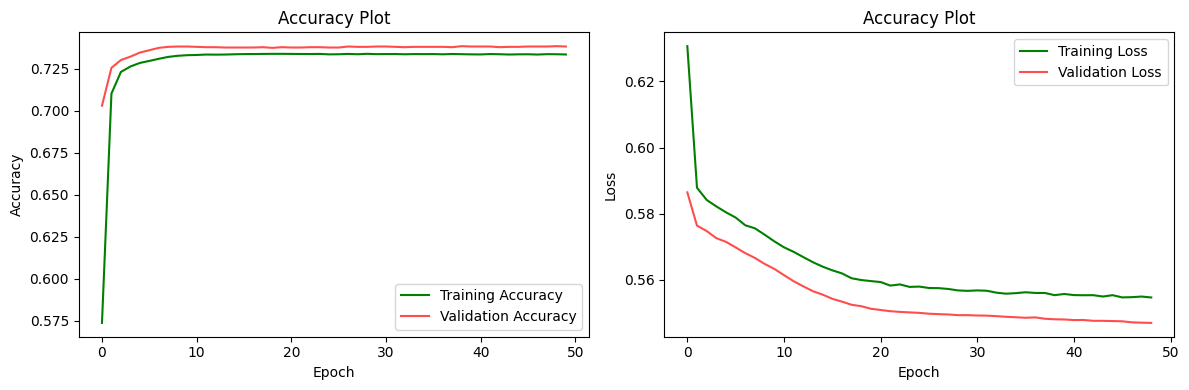

In [46]:
from backend.utils.visualizing_service import plot_model_accuracy
plot_model_accuracy(history)